In [1]:
import os
import warnings
import joblib
from typing import Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

c:\Users\Arnav Waghdhare\Desktop\Arnav20\Coding\Python\Arthya\ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def load_dataset(csv_path: str) -> pd.DataFrame:
	df = pd.read_csv(csv_path)
	if "ds" not in df.columns or "y" not in df.columns:
		raise ValueError("Input CSV must contain 'ds' and 'y' columns")
	df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
	df = df.sort_values("ds").reset_index(drop=True)
	df = df.dropna(subset=["ds", "y"])  # ensure target/date exist
	# Fill all remaining NaN values with 0
	df = df.fillna(0)
	return df

In [3]:
def time_series_split(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
	n = len(df)
	split_idx = int(n * (1 - test_size))
	train_df = df.iloc[:split_idx].copy()
	test_df = df.iloc[split_idx:].copy()
	return train_df, test_df

In [4]:
def build_feature_transformer(df: pd.DataFrame, feature_cols: List[str]) -> ColumnTransformer:
	# Object or string-like columns are treated as categoricals
	cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
	num_cols = [c for c in feature_cols if c not in cat_cols]

	transformer = ColumnTransformer(
		transformers=[
			("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
			("num", "passthrough", num_cols),
		],
		remainder="drop",
	)
	return transformer

In [19]:
def fit_prophet(train_df: pd.DataFrame, regressor_df: pd.DataFrame, feature_names: List[str]) -> Prophet:
	safe_feature_names = [name for name in feature_names if name not in ['ds', 'y', 'cap', 'floor']] 
	m = Prophet()
	# Filter out any feature names that conflict with Prophet's reserved columns
	for name in safe_feature_names:
		m.add_regressor(name)
	train_for_prophet = pd.DataFrame({
		"ds": train_df["ds"].values,
		"y": train_df["y"].values,
		**{name: regressor_df[name].values for name in safe_feature_names},
	})
	m.fit(train_for_prophet)
	return m

In [6]:
def prophet_predict(m: Prophet, df: pd.DataFrame, regressor_df: pd.DataFrame, feature_names: List[str]) -> pd.DataFrame:
	# Filter out any feature names that conflict with Prophet's reserved columns
	safe_feature_names = [name for name in feature_names if name not in ['ds', 'y', 'cap', 'floor']]
	future = pd.DataFrame({
		"ds": df["ds"].values,
		**{name: regressor_df[name].values for name in safe_feature_names},
	})
	forecast = m.predict(future)
	return forecast

In [7]:
def create_residual_sequences(residuals: np.ndarray, daily_income: np.ndarray, regressors: np.ndarray, seq_len: int = 14) -> Tuple[np.ndarray, np.ndarray]:
	X, y = [], []
	for i in range(seq_len, len(residuals)):
		# Use a window of regressors aligned to time, optionally stack residuals too
		X.append(regressors[i - seq_len:i])  # shape (seq_len, n_features)
		y.append(residuals[i])
	X = np.array(X)
	y = np.array(y)
	return X, y

In [8]:
def build_lstm(input_shape:Tuple[int, int]) -> Sequential:
	model = Sequential([
		LSTM(32, return_sequences=False, input_shape=input_shape),
		Dense(16, activation="relu"),
		Dense(1),
	])
	model.compile(optimizer="adam", loss="mse")
	return model

In [ ]:
def train_prophet_lstm(csv_path: str,
						test_size: float = 0.2,
						seq_len: int = 30,
						epochs: int = 100,
						batch_size: int = 32,
						models_dir: str = "models"):
	df = load_dataset(csv_path)
	
	df = df.drop(columns=['Job_Categories', "Job_Duration_Days", "Target_Income_Next_Day", "Month", "Monthly_Income", "Monthly_Expenses", "Target_Income_Next_Month", "Income_Total"], errors='ignore')
	
	# Identify features
	feature_cols = [c for c in df.columns if c not in ["ds", "y"]]
	print(f"Using features: {feature_cols}")
	transformer = build_feature_transformer(df, feature_cols)

	# Fit transformer on train only to avoid leakage
	train_df, test_df = time_series_split(df, test_size=test_size)

	# Build a pipeline solely for transformation (fit on train -> transform train/test)
	feature_pipe = Pipeline(steps=[("transform", transformer)])
	X_train_raw = train_df[feature_cols]
	X_test_raw = test_df[feature_cols]

	X_train = feature_pipe.fit_transform(X_train_raw)
	X_test = feature_pipe.transform(X_test_raw)

	# Clean transformed data - replace NaN/Inf with 0
	X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
	X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

	# Retrieve transformed feature names for Prophet regressors
	cat_cols = transformer.transformers_[0][2] if transformer.transformers_ else []
	num_cols = transformer.transformers_[1][2] if transformer.transformers_ else []
	# For OrdinalEncoder, feature names are just the column names
	feature_names = list(cat_cols) + list(num_cols)

	# Build dataframes for regressors matching Prophet expectations
	reg_train_df = pd.DataFrame(X_train, columns=feature_names, index=train_df.index)
	reg_test_df = pd.DataFrame(X_test, columns=feature_names, index=test_df.index)

	# Train Prophet with regressors on train set
	prophet_model = fit_prophet(train_df, reg_train_df, feature_names)

	# Prophet predictions for train and test
	forecast_train = prophet_predict(prophet_model, train_df, reg_train_df, feature_names)
	forecast_test = prophet_predict(prophet_model, test_df, reg_test_df, feature_names)
	prophet_model.plot_components(forecast_test)

	y_train = train_df["y"].values
	y_test = test_df["y"].values
	yhat_train = forecast_train["yhat"].values
	yhat_test = forecast_test["yhat"].values

	residuals_train = y_train - yhat_train
	residuals_test = y_test - yhat_test

	# Prepare sequences for LSTM using transformed regressors
	X_seq_train, y_seq_train = create_residual_sequences(residuals_train, train_df['y'].values, reg_train_df.values, seq_len=seq_len)
	# For test, to forecast residuals at time t, we also need preceding window; here we build purely within the test set
	X_seq_test, y_seq_test = create_residual_sequences(residuals_test, test_df['y'].values, reg_test_df.values, seq_len=seq_len)

	if len(X_seq_train) == 0 or len(X_seq_test) == 0:
		raise ValueError("Not enough data to build sequences. Consider reducing seq_len or providing more data.")

	# lstm_model = build_lstm((X_seq_train.shape[1], X_seq_train.shape[2]))
	lstm_model = build_lstm((X_seq_train.shape[1], X_seq_train.shape[2]))
	es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
	lstm_model.fit(X_seq_train, y_seq_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

	# Predict residuals on test sequences
	pred_residuals_test = lstm_model.predict(X_seq_test, verbose=0).reshape(-1)

	# Align final evaluation: prophet yhat for the portion that matches y_seq_test indices
	# y_seq_test starts from index seq_len within test segment
	aligned_yhat_test = yhat_test[seq_len:seq_len + len(pred_residuals_test)]
	aligned_y_test = y_test[seq_len:seq_len + len(pred_residuals_test)]

	final_pred_test = aligned_yhat_test + pred_residuals_test

	mae = mean_absolute_error(aligned_y_test, final_pred_test)
	rmse = np.sqrt(mean_squared_error(aligned_y_test, final_pred_test))

	# Get test dates for aligned predictions
	test_dates = test_df["ds"].values[seq_len:seq_len + len(pred_residuals_test)]

	os.makedirs(models_dir, exist_ok=True)
	# Save LSTM via Keras
	lstm_model.save(os.path.join(models_dir, "lstm_residual_model.keras"))
	# Save feature pipeline using joblib
	joblib.dump(feature_pipe, os.path.join(models_dir, "feature_pipeline.joblib"))

	return {
		"mae": mae,
		"rmse": rmse,
		"test_predictions": final_pred_test,
		"test_actual": aligned_y_test,
		"prophet_predictions": aligned_yhat_test,
		"test_dates": test_dates,
		"seq_len": seq_len,
	}

In [10]:
def plot_forecasts(results: dict, save_path: str = "models/forecast_plot.png"):
	"""Plot actual vs predicted values for Prophet, LSTM, and combined model."""
	fig, axes = plt.subplots(2, 1, figsize=(14, 10))
	
	dates = results["test_dates"]
	actual = results["test_actual"]
	prophet_pred = results["prophet_predictions"]
	combined_pred = results["test_predictions"]
	
	# Plot 1: Prophet vs Combined Prophet+LSTM
	axes[0].plot(dates, actual, label="Actual", color="black", linewidth=2, marker='o', markersize=4)
	axes[0].plot(dates, prophet_pred, label="Prophet Only", color="blue", linewidth=1.5, linestyle='--', alpha=0.7)
	axes[0].plot(dates, combined_pred, label="Prophet + LSTM", color="red", linewidth=1.5, alpha=0.8)
	axes[0].set_title("Prophet vs Prophet+LSTM Forecast", fontsize=14, fontweight='bold')
	axes[0].set_xlabel("Date", fontsize=12)
	axes[0].set_ylabel("Income Total", fontsize=12)
	axes[0].legend(loc='best', fontsize=10)
	axes[0].grid(True, alpha=0.3)
	axes[0].tick_params(axis='x', rotation=45)
	
	# Plot 2: Residuals comparison
	prophet_residuals = actual - prophet_pred
	combined_residuals = actual - combined_pred
	axes[1].plot(dates, prophet_residuals, label="Prophet Residuals", color="blue", linewidth=1.5, alpha=0.7)
	axes[1].plot(dates, combined_residuals, label="Prophet+LSTM Residuals", color="red", linewidth=1.5, alpha=0.7)
	axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
	axes[1].set_title("Prediction Residuals", fontsize=14, fontweight='bold')
	axes[1].set_xlabel("Date", fontsize=12)
	axes[1].set_ylabel("Residuals", fontsize=12)
	axes[1].legend(loc='best', fontsize=10)
	axes[1].grid(True, alpha=0.3)
	axes[1].tick_params(axis='x', rotation=45)
	
	plt.tight_layout()
	# plt.savefig(save_path, dpi=150, bbox_inches='tight')
	print(f"Forecast plot saved to: {save_path}")
	plt.show()

03:57:34 - cmdstanpy - INFO - Chain [1] start processing


Using features: ['Job_Type', 'Hours_Worked', 'Platform_Count', 'Local_Gas_Price', 'Expenses_Total', 'Public_Holiday_Flag', 'Monthly_Unemployment_Rate', 'income_volatility_index', 'income_rolling_avg_3m', 'expense_to_income_ratio', 'net_Income', 'savings']


03:57:34 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.01, RMSE: 0.01, seq_len: 30


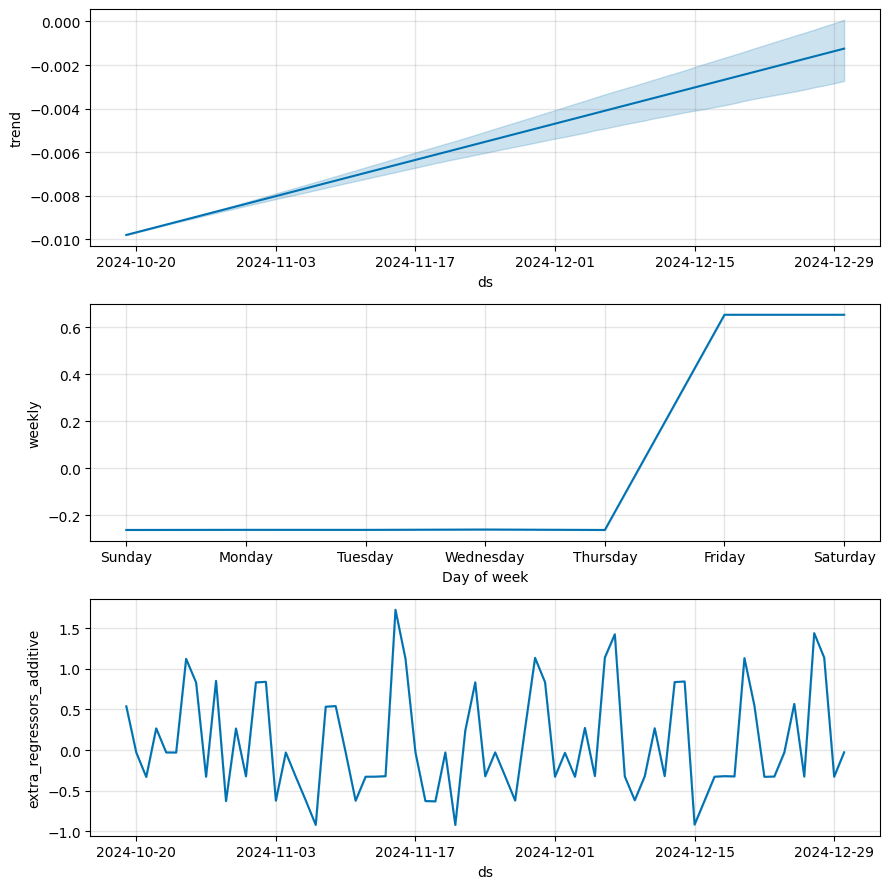

In [11]:
csv_path = "./features_a.csv"
results = train_prophet_lstm(csv_path)
print(f"MAE: {results['mae']:.2f}, RMSE: {results['rmse']:.2f}, seq_len: {results['seq_len']}")

Forecast plot saved to: models/forecast_plot.png


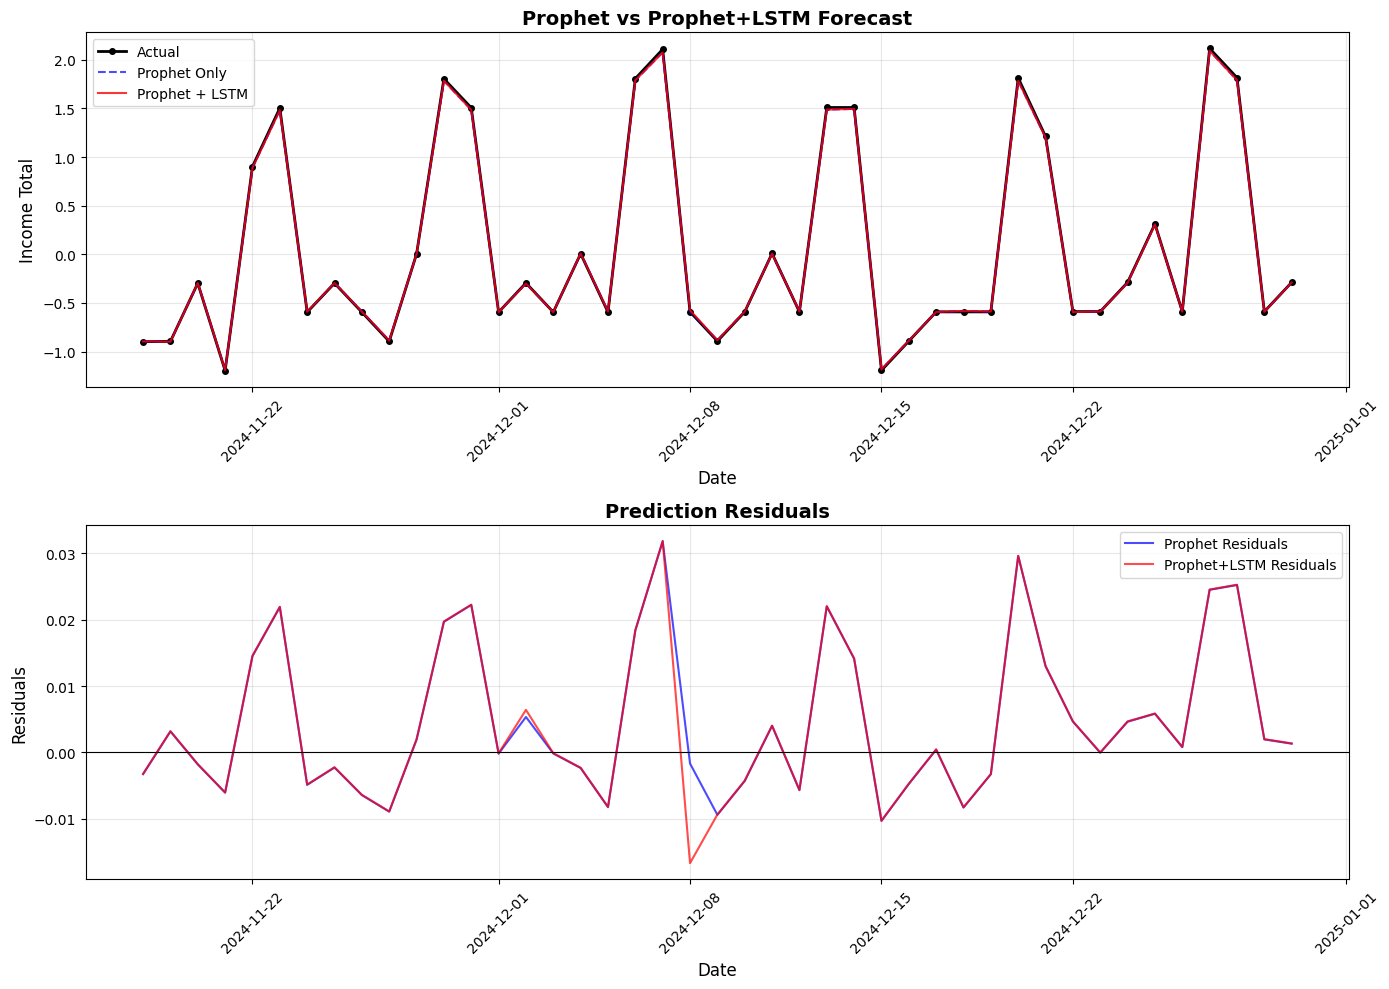

In [12]:
# Plot forecasts
plot_forecasts(results)

## Training on the Feature B 

In [ ]:
def retrain_prophet_lstm_with_existing_models(csv_path: str,
												lstm_model_path: str = "models/lstm_residual_model.keras",
												feature_pipeline_path: str = "models/feature_pipeline.joblib",
												test_size: float = 0.2,
												seq_len: int = 30,
												epochs: int = 100,
												batch_size: int = 32,
												models_dir: str = "models"):
	print("Loading dataset...")
	df = load_dataset(csv_path)
	
	df = df.drop(columns=['Job_Categories', "Job_Duration_Days", "Target_Income_Next_Day", "Month", 
						  "Monthly_Income", "Monthly_Expenses", "Target_Income_Next_Month", "Income_Total"], errors='ignore')
	
	# Identify features
	feature_cols = [c for c in df.columns if c not in ["ds", "y"]]
	print(f"Using features: {feature_cols}")
	
	# Load existing feature pipeline
	print(f"Loading feature pipeline from {feature_pipeline_path}...")
	try:
		feature_pipe = joblib.load(feature_pipeline_path)
		print("Feature pipeline loaded successfully!")
	except Exception as e:
		print(f"Warning: Could not load feature pipeline ({e}). Creating new one...")
		cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
		num_cols = [c for c in feature_cols if c not in cat_cols]
		transformer = ColumnTransformer(
			transformers=[
				("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
				("num", "passthrough", num_cols),
			],
			remainder="drop",
		)
		feature_pipe = Pipeline(steps=[("transform", transformer)])

	# Split data
	train_df, test_df = time_series_split(df, test_size=test_size)
	
	# Transform features using the loaded pipeline
	X_train_raw = train_df[feature_cols]
	X_test_raw = test_df[feature_cols]
	
	# Fit or refit the pipeline on new training data
	X_train = feature_pipe.fit_transform(X_train_raw)
	X_test = feature_pipe.transform(X_test_raw)
	
	# Clean transformed data - replace NaN/Inf with 0
	X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
	X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
	
	# Retrieve transformed feature names
	transformer = feature_pipe.named_steps["transform"]
	cat_cols = transformer.transformers_[0][2] if transformer.transformers_ else []
	num_cols = transformer.transformers_[1][2] if len(transformer.transformers_) > 1 else []
	# For OrdinalEncoder, feature names are just the column names
	feature_names = list(cat_cols) + list(num_cols)
	
	# Build dataframes for regressors
	reg_train_df = pd.DataFrame(X_train, columns=feature_names, index=train_df.index)
	reg_test_df = pd.DataFrame(X_test, columns=feature_names, index=test_df.index)
	
	# Validate data before Prophet
	print(f"\nData validation:")
	print(f"X_train shape: {X_train.shape}, NaN count: {np.isnan(X_train).sum()}")
	print(f"X_test shape: {X_test.shape}, NaN count: {np.isnan(X_test).sum()}")
	print(f"y_train range: [{train_df['y'].min():.2f}, {train_df['y'].max():.2f}]")
	print(f"Features: {feature_names}")
	
	# Train Prophet with regressors
	print("\nTraining Prophet model...")
	prophet_model = fit_prophet(train_df, reg_train_df, feature_names)
	
	# Prophet predictions
	forecast_train = prophet_predict(prophet_model, train_df, reg_train_df, feature_names)
	forecast_test = prophet_predict(prophet_model, test_df, reg_test_df, feature_names)
	prophet_model.plot_components(forecast_test)
	
	y_train = train_df["y"].values
	y_test = test_df["y"].values
	yhat_train = forecast_train["yhat"].values
	yhat_test = forecast_test["yhat"].values
	
	residuals_train = y_train - yhat_train
	residuals_test = y_test - yhat_test
	
	# Prepare sequences for LSTM
	print(f"Creating sequences with seq_len={seq_len}...")
	X_seq_train, y_seq_train = create_residual_sequences(residuals_train, train_df['y'].values, reg_train_df.values, seq_len=seq_len)
	X_seq_test, y_seq_test = create_residual_sequences(residuals_test, test_df['y'].values, reg_test_df.values, seq_len=seq_len)
	
	if len(X_seq_train) == 0 or len(X_seq_test) == 0:
		raise ValueError("Not enough data to build sequences. Consider reducing seq_len or providing more data.")
	
	# Load existing LSTM model or create new one
	print(f"Loading LSTM model from {lstm_model_path}...")
	try:
		lstm_model = tf.keras.models.load_model(lstm_model_path)
		print("Existing LSTM model loaded successfully!")
		
		# Check if input shape matches
		expected_shape = (X_seq_train.shape[1], X_seq_train.shape[2])
		model_input_shape = lstm_model.input_shape[1:]
		if model_input_shape != expected_shape:
			print(f"Warning: Model input shape {model_input_shape} doesn't match data shape {expected_shape}")
			print("Creating new LSTM model with correct shape...")
			lstm_model = Sequential([
				LSTM(32, return_sequences=False, input_shape=expected_shape),
				Dense(16, activation="relu"),
				Dense(1),
			])
			lstm_model.compile(optimizer="adam", loss="mse")
	except Exception as e:
		print(f"Warning: Could not load LSTM model ({e}). Creating new one...")
		lstm_model = Sequential([
			LSTM(32, return_sequences=False, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
			Dense(16, activation="relu"),
			Dense(1),
		])
		lstm_model.compile(optimizer="adam", loss="mse")
	
	# Retrain LSTM on new data
	print("Retraining LSTM model...")
	es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
	history = lstm_model.fit(X_seq_train, y_seq_train, 
							 validation_split=0.2, 
							 epochs=epochs, 
							 batch_size=batch_size, 
							 callbacks=[es], 
							 verbose=1)
	
	# Predict residuals on test sequences
	pred_residuals_test = lstm_model.predict(X_seq_test, verbose=0).reshape(-1)
	
	# Align final evaluation
	aligned_yhat_test = yhat_test[seq_len:seq_len + len(pred_residuals_test)]
	aligned_y_test = y_test[seq_len:seq_len + len(pred_residuals_test)]
	
	final_pred_test = aligned_yhat_test + pred_residuals_test
	
	mae = mean_absolute_error(aligned_y_test, final_pred_test)
	rmse = np.sqrt(mean_squared_error(aligned_y_test, final_pred_test))
	
	# Get test dates for aligned predictions
	test_dates = test_df["ds"].values[seq_len:seq_len + len(pred_residuals_test)]
	
	# Save retrained models
	os.makedirs(models_dir, exist_ok=True)
	lstm_save_path = os.path.join(models_dir, "lstm_residual_model.keras")
	lstm_model.save(lstm_save_path)
	print(f"Retrained LSTM model saved to: {lstm_save_path}")
	
	pipeline_save_path = os.path.join(models_dir, "feature_pipeline.joblib")
	joblib.dump(feature_pipe, pipeline_save_path)
	print(f"Feature pipeline saved to: {pipeline_save_path}")
	
	print(f"\nRetraining Results:")
	print(f"MAE: {mae:.2f}")
	print(f"RMSE: {rmse:.2f}")
	
	return {
		"mae": mae,
		"rmse": rmse,
		"test_predictions": final_pred_test,
		"test_actual": aligned_y_test,
		"prophet_predictions": aligned_yhat_test,
		"test_dates": test_dates,
		"seq_len": seq_len,
	}

In [21]:
csv_path = "features_b.csv"
lstm_model_path = "models/lstm_residual_model.keras"
feature_pipeline_path = "models/feature_pipeline.joblib"

results = retrain_prophet_lstm_with_existing_models(
    csv_path=csv_path,
    lstm_model_path=lstm_model_path,
    feature_pipeline_path=feature_pipeline_path,
    test_size=0.2,
    seq_len=30,
    epochs=100,
    batch_size=32
)

print(f"\nFinal Metrics:")
print(f"MAE: {results['mae']:.2f}")
print(f"RMSE: {results['rmse']:.2f}")
print(f"Sequence Length: {results['seq_len']}")

04:03:36 - cmdstanpy - INFO - Chain [1] start processing


Loading dataset...
Using features: ['Job_Type', 'Public_Holiday_Flag', 'Local_Gas_Price', 'Monthly_Unemployment_Rate', 'Jobs_Completed', 'Hours_Worked', 'Expenses_Total', 'Platform_Count', 'income_volatility_index', 'income_rolling_avg_3m', 'expense_to_income_ratio', 'net_Income', 'savings']
Loading feature pipeline from models/feature_pipeline.joblib...
Feature pipeline loaded successfully!

Data validation:
X_train shape: (292, 12), NaN count: 0
X_test shape: (73, 12), NaN count: 0
y_train range: [-0.38, 3.66]
Features: ['Job_Type', 'Hours_Worked', 'Platform_Count', 'Local_Gas_Price', 'Expenses_Total', 'Public_Holiday_Flag', 'Monthly_Unemployment_Rate', 'income_volatility_index', 'income_rolling_avg_3m', 'expense_to_income_ratio', 'net_Income', 'savings']

Training Prophet model...


04:03:37 - cmdstanpy - INFO - Chain [1] done processing


Creating sequences with seq_len=30...
Loading LSTM model from models/lstm_residual_model.keras...
Existing LSTM model loaded successfully!
Retraining LSTM model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0447 - val_loss: 0.0213
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0174 - val_loss: 0.0150
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061 - val_loss: 0.0088
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0035 - val_loss: 0.0084
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0024 - val_loss: 0.0076
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.0077
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - val_loss: 0.0081
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.7116e-04 - val_los

Forecast plot saved to: models/forecast_plot.png


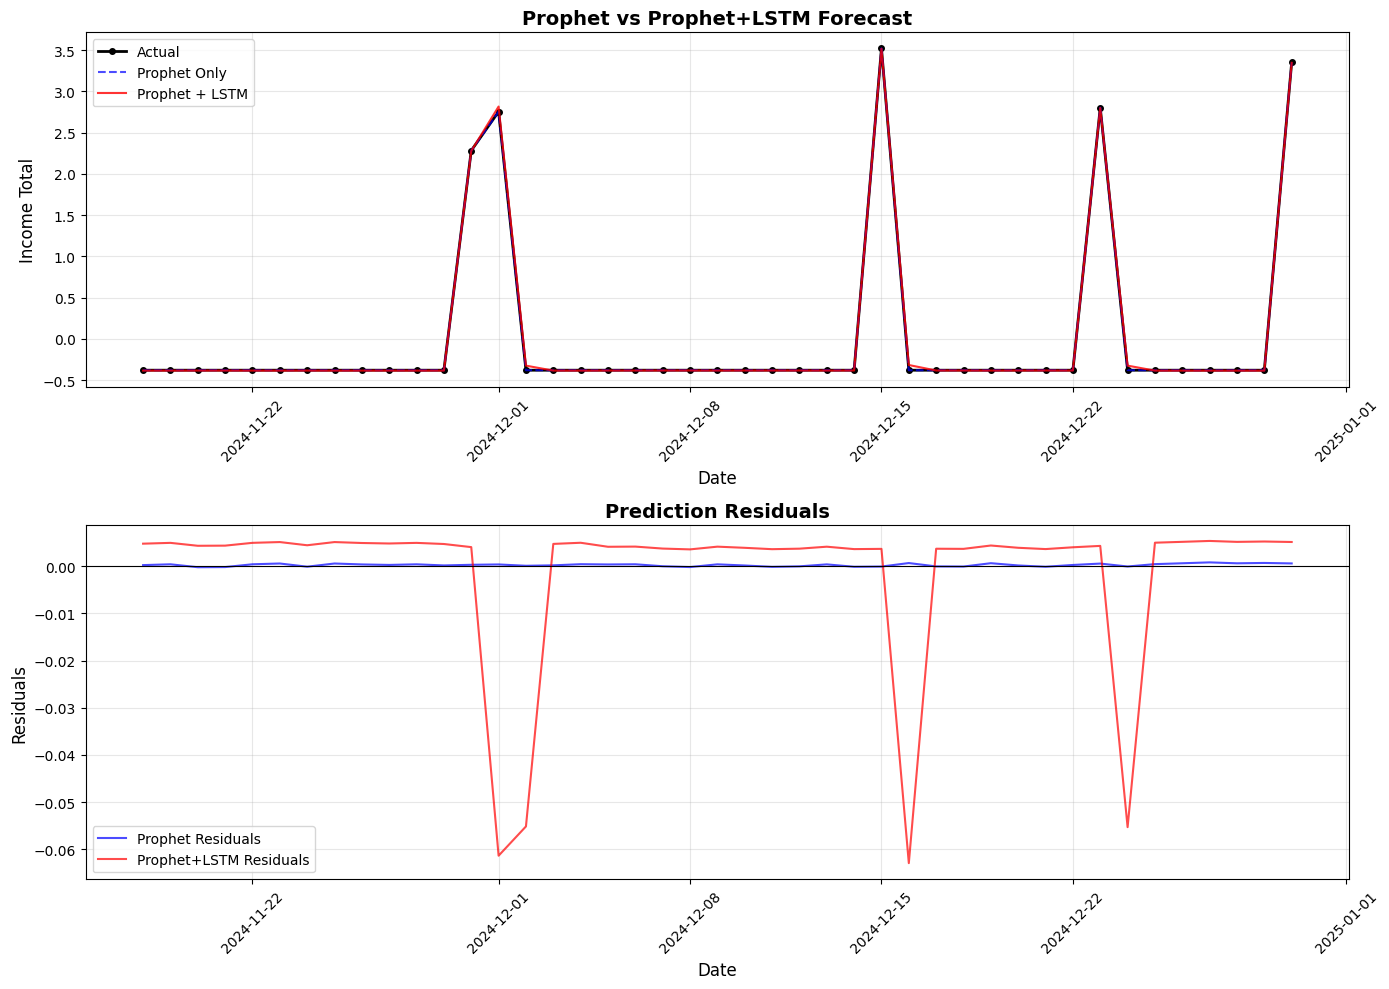

In [22]:
# Plot forecasts
plot_forecasts(results)

## The LSTM model tends to capture noise because of how little residual loss exists from the Prophet model 